In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob
import sys, os

In [3]:
from tqdm import tqdm_notebook as tqdm
import pandas as pd

In [4]:
import time

In [5]:
print os.getpid()

16886


# Keep track of  'Config' in a dictionary

In [6]:
from easydict import EasyDict
C = EasyDict()

# Prepare Data

The images are very high resolution -- the markings themselves are hard to makeout

**NOTE:** The annotations were done using the GiMP software (https://www.gimp.org/) which is just a free alternative to photoshop. The GiMP files are saved with the extension '.xcf' is we decide to edit them. 

In [7]:
#C.RAW_DIR = "./data/raw"
C.RAW_DIR = "./photos"

In [8]:
train_images =  pd.read_csv('training_images.csv', index_col=0)
train_images

,path,annotation,labels
0,20171225_144320.jpg,20171225_144320.png,20171225_144320.npy
1,20171225_145418.jpg,20171225_145418.png,20171225_145418.npy
2,20171225_145014.jpg,20171225_145014.png,20171225_145014.npy
3,20171225_145147.jpg,20171225_145147.png,20171225_145147.npy
4,20171225_145110.jpg,20171225_145110.png,20171225_145110.npy
5,20171225_144355.jpg,20171225_144355.png,20171225_144355.npy
6,20171225_145244.jpg,20171225_145244.png,20171225_145244.npy
7,20171225_144348.jpg,20171225_144348.png,20171225_144348.npy
8,20171225_145154.jpg,20171225_145154.png,20171225_145154.npy
9,20171225_145229.jpg,20171225_145229.png,20171225_145229.npy


In [9]:
eval_images = pd.read_csv('evaluation_images.csv', index_col=0)
eval_images

,path,annotation,labels
0,20171225_144400.jpg,20171225_144400.png,20171225_144400.npy
1,20171225_144357.jpg,20171225_144357.png,20171225_144357.npy
2,20171225_145022.jpg,20171225_145022.png,20171225_145022.npy
4,20171225_144403.jpg,20171225_144403.png,20171225_144403.npy
5,20171225_145425.jpg,20171225_145425.png,20171225_145425.npy
7,20171225_145224.jpg,20171225_145224.png,20171225_145224.npy
8,20171225_145032.jpg,20171225_145032.png,20171225_145032.npy
10,20171225_145215.jpg,20171225_145215.png,20171225_145215.npy
11,20171225_145241.jpg,20171225_145241.png,20171225_145241.npy
12,20171225_145150.jpg,20171225_145150.png,20171225_145150.npy


In [10]:
import PIL.Image
from PIL.ExifTags import TAGS

def fix_orientation(img):
    try:
        exif = {TAGS[k]:v for k,v in img._getexif().items()}
    except AttributeError:
        return img
    
    o = exif['Orientation']
    if o == 1:
        return img
    elif o == 2:
        return img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    elif o == 3:
        return img.rotate(180)
    else:
        assert False, "I was too lazy to continue from https://magnushoff.com/jpeg-orientation.html"
        
def open_image(path):
    return fix_orientation(PIL.Image.open(path))    

In [11]:
# target_paths = glob(os.path.join(C.RAW_DIR, '*.png'))
# data_paths = [path.replace('.png', '.jpg') for path in target_paths if os.path.isfile(path.replace('.png', '.jpg'))]

data_paths = [os.path.join(C.RAW_DIR, p) for p in train_images['path']]
target_paths = [os.path.join(C.RAW_DIR, p) for p in train_images['annotation']]

data_paths += [os.path.join(C.RAW_DIR, p) for p in eval_images['path']]
target_paths += [os.path.join(C.RAW_DIR, p) for p in eval_images['annotation']]


In [12]:
figure()
if os.path.isdir(C.RAW_DIR):
    imshow(open_image(data_paths[0]));

<IPython.core.display.Javascript object>

## Resize so min dimension is 600

In [13]:
C.MIN_IMAGE_DIMENSION=600
C.INTERIM_DIR = './data/interim'

In [14]:
if not os.path.isdir(C.INTERIM_DIR): os.makedirs(C.ITERIM_DIR)

In [15]:
files = []
force = False
for data_path, target_path in tqdm(zip(data_paths, target_paths)):
    new_data_path = os.path.join(C.INTERIM_DIR, os.path.relpath(data_path, C.RAW_DIR))
    new_target_path = os.path.join(C.INTERIM_DIR, os.path.relpath(target_path, C.RAW_DIR))
    
    if force or not os.path.isfile(new_data_path) or not os.path.isfile(new_data_path): 
        data = open_image(data_path)
        target = open_image(target_path)

        scale = 600./min(data.size)
        new_size = (int(round(data.size[0]*scale)), int(round(data.size[1]*scale)))
        data = data.resize(new_size)
        target = target.resize(new_size, resample=PIL.Image.NEAREST)

        data.save(new_data_path, quality=100)
        target.save(new_target_path)
    files.append((new_data_path, new_target_path))

In [16]:
figure()
imshow(imread(files[0][0]));

<IPython.core.display.Javascript object>

## Replace colors by indexes

In [17]:
colors = np.array([
    (0, 0, 0),
    (255, 0, 0),
    (255, 255,0),
    (255, 255,255),
    (0, 0, 255),
    (0, 255, 0),
    (127, 127, 0),
    #(127, 0, 127),
    #(0, 255, 255)
])

ignore = (127, 127, 127)

long_names = [
    'k: Not Marked',
    'r: Electric Power',
    'y: Gas,Oil,Dangerous Material',
    'w: Proposed Excavation',
    'b: Water Systems, Slurry Pipelines',
    'g: Sanitary Sewer Systems',
    'l: Faded Mark',
    #'p: Reclaimed Water',
    #'c: Cyan (Unknown) Marking'
]

names = [
    'k:None',
    'r:Power',
    'y:Gas',
    'w:Excavation',
    'b:Water',
    'g:Sewer',
    'l:Faded',
    #'p:Reclaimed',
    #'c:Unknown'
]

In [18]:
def convert(path):
    """Convert annotations --> npy. 
    
    path: Color-coded annotatations
    """
    img = open_image(path)
    data = array(img)
    shape = data.shape
    data = data.reshape(-1, 4)[:,:3]

    data[data > 191] =  255
    data[data < 100] = 0
    data[(data != 0) & (data != 255)] = 127

    indices = np.zeros(len(data), dtype=np.uint8)
    for i in range(1, len(colors)):
        indices[(data == colors[i]).all(1)] = i
    
    # The "cyan" label was just a feded water marker, fix that here..
    indices[(data == (0, 255, 255)).all(1)] = names.index('b:Water')
    
    indices = indices.reshape(shape[:2])
    
    np.save(path.replace('.png', '.npy'), indices)    

In [19]:
force = False
for rec  in tqdm(files):
    data_path = rec[0]
    target_path = rec[1]
    if force or not os.path.isfile(target_path.replace('.png', '.npy')):
        convert(target_path)

In [20]:
# figsize(10,5)
# for i in range(len(files)):
#     figure()
#     subplot(121)
#     imshow(open_image(files[i][0]))
#     subplot(122)
#     imshow(open_image(files[i][1]))

# Create a torch dataset

Torch can be installed from https://pytorch.org/get-started/locally/

In [21]:
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

In [22]:
C.INPUT_SIZE=256

In [23]:
class BlueStakeData(torch.utils.data.Dataset):
    def __init__(self, folder, df):
        self.folder = folder
        
        
        self.labels = [os.path.join(self.folder, fn) for fn in df['labels']]
        self.images = [os.path.join(self.folder, fn) for fn in df['path']]
        
        self.size = (C.INPUT_SIZE, C.INPUT_SIZE)
    
    def crop(self, data, target, size):
        i = np.random.randint(0, target.shape[0] - size[0])
        j = np.random.randint(0, target.shape[1] - size[1])
        data = data[i:i+size[0], j:j+size[1]]
        target = target[i:i+size[0], j:j+size[1]]
        return data, target
    
    def transform(self, data, target):
        data, target = self.crop(data, target, self.size)
        return data, target
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        data = open_image(self.images[i])
        target = np.load(self.labels[i])
        
        data = np.array(data)
        data, target = self.transform(data, target)
        
        data = torchvision.transforms.functional.to_tensor(data)
        target = torch.from_numpy(target)
        
        return data, target   

In [24]:
ds = BlueStakeData(C.INTERIM_DIR, train_images)

In [25]:
eval_ds = BlueStakeData(C.INTERIM_DIR, eval_images)

In [26]:
data, target = eval_ds[4]
print("Data:{}, Target:{}".format(data.shape, target.shape))

figure()
subplot(121)
imshow(data.numpy().transpose(1,2,0))
subplot(122)
imshow(colors[target.numpy()]);

Data:torch.Size([3, 256, 256]), Target:torch.Size([256, 256])


<IPython.core.display.Javascript object>

** There are some errors caused by aliasing during anntoation -- to late to fix now**

## Get the total counts of each label

In [27]:
counts = np.zeros(len(colors))
for data_path, target_image_path, target_npy_path in tqdm(train_images.values):
    targets = np.load(os.path.join(C.INTERIM_DIR, target_npy_path))
    counts += np.bincount(targets.flatten(), minlength=len(counts))    

In [28]:
figure(figsize=(6,4))
bar(arange(len(counts)), counts, color=colors/255., edgecolor='k')
yscale('log')
xticks(range(len(colors)), names, rotation=45)
xlabel("Label")
ylabel("Count (log)")
title("Frequency of Annotations");
tight_layout()
savefig('annotation-freqs.pdf')

<IPython.core.display.Javascript object>

Weights according to [Eigen & Fergus](https://arxiv.org/abs/1411.4734) paper. 
> we weight each pixel by
αc = median freq/freq(c) where freq(c) is the number
of pixels of class c divided by the total number of pixels in
images where c is present, and median freq is the median
of these frequencies

In [29]:
im_counts = np.zeros((len(names), len(names)))

for data_path, target_image_path, target_npy_path in tqdm(train_images.values):
    targets = np.load(os.path.join(C.INTERIM_DIR, target_npy_path))
    counts_im = np.bincount(targets.flatten(), minlength=len(names)) 
    for i in range(len(names)):
        if counts_im[i] > 0:
            im_counts[i] += counts_im

In [30]:
weights = array([median(im_counts[i])/im_counts[i,i] for i in range(len(names))])

In [31]:
weights = np.median(np.log2(counts))/(np.log2(counts))
#weights = np.median(counts)/counts  # 

In [32]:
weights

array([ 0.61198554,  1.        ,  0.92869146,  1.05576565,  1.08313393,
        1.19003328,  0.95551809])

## Set up a batch loader

In [33]:
def to_array(a):
    if torch.is_tensor(a):
        a = a.detach().numpy()
    return np.array(a)        

In [34]:
def to_image(a):
    return PIL.Image.fromarray(to_array(a).transpose(1,2,0))

In [35]:
def plot_errors(data, target, pred, alpha=1.):
    if data.shape[0] in (3,4):
        data = data.transpose(1,2,0)
    h, w = data.shape[:2]
    errors = np.zeros((h, w, 4), dtype=np.uint8)
    errors[(target > 0) & (pred > 0) & (target == pred), ...]  = (0,   255, 0,   255) 
    errors[target != pred, ...] = (255, 0,   0,   255)    
 
    imshow(data)
    imshow(errors, alpha=alpha)

In [36]:
def plot_batch(data, targets, preds, nr=4, nc=6, alpha=0.5):
    for i in range(len(data)):
        subplot(nr, nc, i+1)
        d = to_array(data[i])
        t = to_array(targets[i])
        if preds is None:
            p = np.zeros_like(t)
        else:
            p = to_array(preds[i])
        plot_errors(d, t, p, alpha=alpha)
        xticks([])
        yticks([])
        xlabel("{}".format(i))

In [37]:
C.BATCH_SIZE=5
C.NUM_WORKERS=10
C.EPOCH_SIZE=1000

In [38]:

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=ones(len(ds)), 
                                                         num_samples=C.EPOCH_SIZE,
                                                         replacement=True)                                                      
trainloader = torch.utils.data.DataLoader(ds, batch_size=C.BATCH_SIZE, num_workers=C.NUM_WORKERS, sampler=sampler)
                               

In [39]:
eval_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=ones(len(eval_ds)), 
                                                         num_samples=C.EPOCH_SIZE/10,
                                                         replacement=True)                                                      
eval_loader = torch.utils.data.DataLoader(eval_ds, 
                                          batch_size=C.BATCH_SIZE, 
                                          num_workers=C.NUM_WORKERS, 
                                          sampler=eval_sampler)
                               

In [40]:
bd, bt = iter(eval_loader).next()

In [41]:
figure()
plot_batch(bd, bt, None, alpha=0.8, nr=2, nc=3)
tight_layout()

<IPython.core.display.Javascript object>

# Choose a network architecture

I will try https://github.com/jaxony/unet-pytorch

In [42]:
# !wget -P unet https://raw.githubusercontent.com/jaxony/unet-pytorch/master/model.py

In [43]:
%run unet/model.py

unet/model.py:211: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
unet/model.py:212: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [44]:
model = UNet(len(colors), depth=5, merge_mode='concat')

In [45]:
torch.cuda.is_available()

True

In [46]:
if torch.cuda.is_available():
    def gpu(x):
        return x.cuda()
else:
    def gpu(x):x

In [47]:
model = gpu(model)

# Choose the loss / critera for training

*I am using the weights I determined earlier, based on the log-ratios of the different classes*

In [48]:
criterion = nn.CrossEntropyLoss(weight=gpu(torch.from_numpy(weights).to(torch.float)))

In [49]:
learning_rate = 0.001
weight_decay = 0.0001

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## One epoch

In [51]:
C

{'BATCH_SIZE': 5,
 'EPOCH_SIZE': 1000,
 'INPUT_SIZE': 256,
 'INTERIM_DIR': './data/interim',
 'MIN_IMAGE_DIMENSION': 600,
 'NUM_WORKERS': 10,
 'RAW_DIR': './photos'}

In [52]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        
def resume(model, optimizer, fn='checkpoint.pth.tar'):
    if os.path.isfile(fn):
        print("=> loading checkpoint '{}'".format(fn))
        checkpoint = torch.load(fn)
        start_epoch = checkpoint['epoch']
        ehist=  checkpoint.get('ehist', [])
        thist=  checkpoint.get('thist',[])
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(fn, checkpoint['epoch']))
    else:
        start_epoch = 0
        ehist=[]
        thist=[]
        print("=> no checkpoint found at '{}'".format(fn))
    return start_epoch, ehist, thist

In [53]:
def evaluate(model, loader):
    with torch.no_grad():
        running_loss = 0.0
        for i, data in tq.tqdm(enumerate(eval_loader),
                        desc="Evalutating",
                        file=sys.stdout,
                        total=len(eval_loader), 
                        leave=False):
            inputs, labels = data
            inputs = gpu(inputs)
            labels = gpu(labels.to(torch.long))
            outputs = model(inputs)
            outputs = outputs.permute(0, 2, 3, 1).reshape(-1, model.num_classes)
            labels = labels.reshape(-1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
        running_loss /= len(eval_loader)
    return running_loss    

In [54]:
#!rm checkpoint.pth.tar

In [55]:
epoch, ehist, thist = resume(model, optimizer);

=> no checkpoint found at 'checkpoint.pth.tar'


In [56]:
C.NUM_EPOCHS = epoch  # Leav it like this to do nor more training, or increase to continue

MINUTES=60
HOURS=60*MINUTES
secs_avail = 3*HOURS  # Fill this in to train more based on time avialable
secs_per_epoch = 140
C.NUM_EPOCHS= epoch + secs_avail / secs_per_epoch 
print(C.NUM_EPOCHS)

77


In [57]:
C.NUM_EPOCHS = 200

<IPython.core.display.Javascript object>


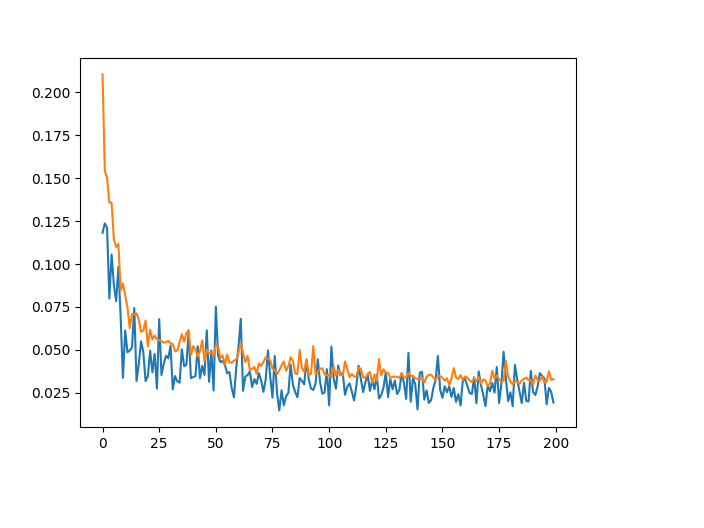

In [58]:
fig = figure()
id_loss_plot = fig.number

In [59]:
import shutil

In [60]:
import tqdm as tq

In [61]:
#!mv best.pth.tar best-unet-2-92-epochs.pth.tar

In [62]:
# if epoch > 100:
#     # Reduce learning rate
#     for grp in optimizer.param_groups: 
#         grp['lr'] = 0.0001
#         grp['weight_decay'] = 0.0001

fig = figure(id_loss_plot)

try:
    ehist = elist[:epoch]
    thist = thist[:epoch]
except:
    ehist = []
    thist = []
    
try:
    print "Best epoch:", best_epoch
except:
    best_epoch = 0
    best_loss = float('inf')

while epoch < C.NUM_EPOCHS:  # loop over the dataset multiple times
    epoch = epoch + 1
    
    running_loss = 0.0
    tstart = time.time()
    for i, data in tq.tqdm(enumerate(trainloader, 0),
                        desc="Training",
                        file=sys.stdout,
                        total=len(trainloader), 
                        leave=False):
        # get the inputs
        inputs, labels = data
        inputs = gpu(inputs)
        labels = gpu(labels.to(torch.long))
        
        n = inputs.shape[0]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.permute(0, 2, 3, 1).reshape(-1, model.num_classes)
        labels = labels.reshape(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    running_loss /= len(trainloader)
    
    eval_loss = evaluate(model, eval_loader)
   
    tend = time.time()
    
    # Plot
    ehist.append(eval_loss)
    thist.append(running_loss)
    clf()
    plot(ehist)
    plot(thist)
    fig.canvas.draw()
    save_checkpoint(dict(
            epoch=epoch,
            state_dict = model.state_dict(),
            optimizer = optimizer.state_dict(), 
            ehist=ehist,
            thist=thist
        ), False)
    
    is_best = eval_loss <  best_loss
    if is_best:
        shutil.copyfile('checkpoint.pth.tar', 'best.pth.tar')
        best_loss = eval_loss
        best_epoch = epoch
        
    # print statistics
    print("Epoch {:03} {}"
          "trn loss:{:10.3f} "
          "evl loss: {:10.3f} "
          " time: {} secs".format(epoch, ('*' if is_best else '-'), running_loss, eval_loss, tend-tstart))

        

print('Finished Training')

 Epoch 001 *trn loss:     0.210 evl loss:      0.118  time: 308.277373075 secs
Epoch 002 -trn loss:     0.154 evl loss:      0.124  time: 307.941133022 secs
Epoch 003 -trn loss:     0.150 evl loss:      0.121  time: 307.304307938 secs
Epoch 004 *trn loss:     0.136 evl loss:      0.080  time: 308.444210052 secs
Epoch 005 -trn loss:     0.136 evl loss:      0.106  time: 305.418605089 secs
Epoch 006 -trn loss:     0.114 evl loss:      0.088  time: 305.416702986 secs
Epoch 007 *trn loss:     0.110 evl loss:      0.078  time: 305.460777998 secs
Epoch 008 -trn loss:     0.112 evl loss:      0.098  time: 305.628274918 secs
Epoch 009 *trn loss:     0.085 evl loss:      0.069  time: 305.74540782 secs
Epoch 010 *trn loss:     0.089 evl loss:      0.034  time: 305.967543125 secs
Epoch 011 -trn loss:     0.082 evl loss:      0.061  time: 305.892369986 secs
Epoch 012 -trn loss:     0.075 evl loss:      0.049  time: 305.792604923 secs
Epoch 013 -trn loss:     0.063 evl loss:      0.050  time: 305.8

In [63]:
#epoch, ehist, thist = resume(model, optimizer, 'best-unet-2-92-epochs.pth.tar')

=> loading checkpoint 'best-unet-2-92-epochs.pth.tar'


RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down_convs.2.conv1.bias", "down_convs.2.conv1.weight", "down_convs.2.conv2.bias", "down_convs.2.conv2.weight", "down_convs.3.conv1.bias", "down_convs.3.conv1.weight", "down_convs.3.conv2.bias", "down_convs.3.conv2.weight", "down_convs.4.conv1.bias", "down_convs.4.conv1.weight", "down_convs.4.conv2.bias", "down_convs.4.conv2.weight", "up_convs.1.upconv.bias", "up_convs.1.upconv.weight", "up_convs.1.conv1.bias", "up_convs.1.conv1.weight", "up_convs.1.conv2.bias", "up_convs.1.conv2.weight", "up_convs.2.upconv.bias", "up_convs.2.upconv.weight", "up_convs.2.conv1.bias", "up_convs.2.conv1.weight", "up_convs.2.conv2.bias", "up_convs.2.conv2.weight", "up_convs.3.upconv.bias", "up_convs.3.upconv.weight", "up_convs.3.conv1.bias", "up_convs.3.conv1.weight", "up_convs.3.conv2.bias", "up_convs.3.conv2.weight". 
	size mismatch for up_convs.0.upconv.bias: copying a param of torch.Size([512]) from checkpoint, where the shape is torch.Size([64]) in current model.
	size mismatch for up_convs.0.upconv.weight: copying a param of torch.Size([1024, 512, 2, 2]) from checkpoint, where the shape is torch.Size([128, 64, 2, 2]) in current model.
	size mismatch for up_convs.0.conv1.bias: copying a param of torch.Size([512]) from checkpoint, where the shape is torch.Size([64]) in current model.
	size mismatch for up_convs.0.conv1.weight: copying a param of torch.Size([512, 1024, 3, 3]) from checkpoint, where the shape is torch.Size([64, 128, 3, 3]) in current model.
	size mismatch for up_convs.0.conv2.bias: copying a param of torch.Size([512]) from checkpoint, where the shape is torch.Size([64]) in current model.
	size mismatch for up_convs.0.conv2.weight: copying a param of torch.Size([512, 512, 3, 3]) from checkpoint, where the shape is torch.Size([64, 64, 3, 3]) in current model.

In [ ]:
figure(figsize=(8,6))
pred = model(bd.cuda())
plot_batch(bd, bt, pred.argmax(1).cpu(), alpha=0.8, nr=2, nc=3)
tight_layout()

In [71]:
from sklearn.metrics import confusion_matrix

In [80]:
def get_cm(model, loader):
    with torch.no_grad():
        cm = np.zeros((model.num_classes, model.num_classes))
        for i, data in tq.tqdm(enumerate(eval_loader),
                        desc="Evalutating",
                        file=sys.stdout,
                        total=len(eval_loader), 
                        leave=False):
            inputs, labels = data
            inputs = gpu(inputs)
            labels = gpu(labels.to(torch.long))
            outputs = model(inputs)
            #outputs = outputs.permute(0, 2, 3, 1).reshape(-1, model.num_classes)
            pred = outputs.cpu().numpy().argmax(1).reshape(-1)
            labels = labels.cpu().numpy().reshape(-1)
            cm += confusion_matrix(labels, pred, labels=arange(model.num_classes))
    
    return cm        

In [104]:
#model.reset_params()

In [116]:
cm = get_cm(model, eval_loader)
recalls = cm.diagonal()/(cm.sum(1)+1e-8)
precisions = cm.diagonal()/(cm.sum(0)+1e-8)
fscores = 2*precisions*recalls/(precisions + recalls + 1e-8)

In [118]:
w =1/(recalls + 1e-8)
w /=  median(w)
w.round(3)

array([ 0.997,  0.981,  1.166,  1.   ,  0.999,  1.349,  1.173])

In [99]:
print weights
print new_weights(weights, cm)

[ 0.0016337   0.33197892  0.21295012  1.          1.          0.79728635
  0.17020368]
[  1.65058152e-03   7.37538219e-01   6.91895231e-01   5.05946321e+00
   3.24530149e+00   1.50634507e+00   1.09863241e+00]


In [97]:
#import seaborn
#figure()
fscores

array([ 0.98977445,  0.45011758,  0.30777798,  0.19764943,  0.30813778,
        0.52928533,  0.15492323])

In [84]:
def clear_tqdm():
    inst = getattr(tq.tqdm, '_instances', None)
    if not inst: return
    try:
        for i in range(len(inst)): inst.pop().close()
    except Exception:
        pass
clear_tqdm()

# Process an entire image

In [ ]:
import skimage.transform

In [ ]:
def process_array(a, model, tsize=256, tstep=128):
    height, width, channels = a.shape
    rows = linspace(0, height-tsize, ceil((height-tsize)/float(tstep)))
    cols = linspace(0, width-tsize, ceil((width-tsize)/float(tstep)))
    windows = [(int(r), int(c), int(r+256), int(c+256)) for r in rows for c in cols]
    
    result = np.zeros((height, width, model.num_classes))
    for window in tqdm(windows, leave=False):
        w = a[window[0]:window[2], window[1]:window[3], :]
        x = torch.tensor([w]).permute(0, 3, 1, 2).to(torch.float)
        p = model(gpu(x)).permute(0, 2, 3, 1)
        result[window[0]:window[2], window[1]:window[3]] += p[0].cpu().detach().numpy()   
    return result

def process_image(im, model, maxdim=600):
    im_ = im.resize( (600*im.width/im.height, 600), resample=PIL.Image.BILINEAR )    
    result = process_array(array(im_)/255., model)
    result = skimage.transform.resize(result, (im.height, im.width))
    return result
 

In [ ]:
im = open_image('photos/20171225_145040.jpg')
result = process_image(im, model)

In [ ]:
figure(figsize=(8,10))
subplot(211)
title('input')
imshow(im)
xticks([]); yticks([]);
subplot(212)
title('prediction (overlaid)')
imshow(im)
imshow(colors[result.argmax(2)], alpha=0.85);
xticks([]); yticks([]);

In [ ]:
def softmax(a, dim=2):
    return exp(a)/exp(a).sum(dim)[:,:,None]

In [ ]:
figure()
title('prediction (soft)')
imshow(im)
imshow(1-softmax(result)[:,:,0], alpha=0.85);
xticks([]); yticks([]);

# Process a video (demo)

This generates a sequence of numbered frames, which can be converted to a video. 
You can play the video with VLC. 

In a terminal:

     ffmpeg -y -i frame-%06d.jpg vid.mp4 
     vlc vid.mp4 -L

In [ ]:
from tqdm import tnrange

In [ ]:
# import imageio
# filename = './photos/20171225_144255.mp4'
# vid = imageio.get_reader(filename,  'ffmpeg')
# print(vid.get_length())
# fig = figure(figsize=(8,6))
# for num in tnrange(vid.get_length()):
#     if not force and os.path.isfile('frame-{:06}.jpg'.format(num)):
#         continue
#     image = vid.get_data(num)/255.
#     image = skimage.transform.resize(image, (600, 600*image.shape[1]/image.shape[0]))
#     result = process_array(image, model)
#     imshow(image)
#     imshow(colors[result.argmax(2)], alpha=0.85);
#     xticks([])
#     yticks([])
#     fig.tight_layout()
#     fig.canvas.draw()
#     savefig('frame-{:06}.jpg'.format(num))
    

In [ ]:
# !mkdir -p inset-video
# fig = figure(figsize=(8,8))
# for num in tnrange(vid.get_length()):
#     clf()
#     axes((0,0,1,1))
#     imshow(imread('frame-{:06}.jpg'.format(num)))
#     axis('off')
#     axes((0.77, 0.605, 0.2, 0.2))
#     imshow(vid.get_data(num))
#     xticks([]); yticks([])
#     fig.canvas.draw()
#     savefig('inset-video/frame-{:06}.jpg'.format(num))

<video width="600" controls src="./inset-vid.mp4" type="video/mp4">
</video>

# Evaluation Metrics

In [ ]:
eval_images

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Placeholder fugures will be drawn in the loop below
figure(101)

In [ ]:
figure(102)

In [ ]:
resume(model, optimizer, fn='good.pth.tar')

In [ ]:
!mkdir -p figs

CONVERT=True

for row in tqdm(eval_images.values):
    data_path, annot_path, label_path = [os.path.join(C.RAW_DIR, p) for p in row]
    
    stem =  os.path.basename(data_path).replace('.jpg','')
    
    eval_im = open_image(data_path)
    
    if CONVERT:
        convert(annot_path)
    
    eval_labels = np.load(label_path)
    
    # Make predictions
    print "Making predictions for", stem 
    pred_scores = process_image(eval_im, model)
    pred_cls = pred_scores.argmax(2)

    # Save predictions for paper 
    print("Saving predictions as a figure")
    fig = figure(101)
    clf()
    imshow(eval_im)
    imshow(colors[pred_cls], alpha=0.8);   
    xticks([]); yticks([])
    axis('scaled')
    tight_layout()
    fig.canvas.draw()
    savefig(os.path.join('figs', stem + '-pred-cls.png'))

#     # Save errors for paper
    print("Saving errors as a figure")
    fig = figure(102)
    clf()
    plot_errors(array(eval_im)*0.25/255, eval_labels, pred_cls)
    xticks([]); yticks([]);   
    axis('scaled')
    tight_layout()
    fig.canvas.draw()
    savefig(os.path.join('figs', stem + '-errors.png'))
    
    # Save classification report
    print "Classification report for", stem 
    with open(os.path.join('figs', stem + '-report.txt'), 'w') as f:
        f.write(classification_report(eval_labels.flatten(),
                            pred_cls.flatten(), 
                            sample_weight=weights[eval_labels].flatten(),
                            labels=arange(len(names)),
                            target_names=names
                           )   
               )
    
    # Save the confusion matrixx
    print "Confusion matrix for", stem
    cm = np.zeros((len(names), len(names)))
    cm = confusion_matrix(eval_labels.flatten(), pred_cls.flatten(), labels=arange(len(names)))
    assert(cm.shape == (9,9))
    np.save(os.path.join('figs', stem + '-cm.npy'), cm)    

Image Stats

In [ ]:
skip = {'20171225_145210.jpg', # No markings
        '20171225_145221.jpg', # No markings
        '20171225_145045.jpg', # Marking of unknown color
       }

In [ ]:
cm = np.zeros((len(names), len(names)))
np.set_printoptions(precision=2, suppress=True, )
for image in eval_images['path']:
    bn =  os.path.basename(image)
    im_cm = np.load(os.path.join('figs', bn.replace('.jpg', '-cm.npy')))
    counts = im_cm.sum(1)
    all_bg = sum(counts) == counts[0]
    if bn in skip:
        print bn, "Skip"
    else:
        print bn, ' '.join(["{:0.2f}".format(x) for x in counts])
    cm += im_cm

In [ ]:
import seaborn

In [ ]:
cm[4,:] += cm[8,:]
cm = cm[:7,:7]
fix_names = array(names)[:7]

In [ ]:
eps = 1e-8

In [ ]:
figure(figsize=(6,4))
balanced_cm =  cm/(cm.sum(1)[:,None]+eps)
seaborn.heatmap(balanced_cm, fmt=".1%", annot=balanced_cm, cbar=False, 
                xticklabels=fix_names, yticklabels=fix_names);
locs, labels = xticks()
xticks(locs, labels, rotation=45)

# locs, labels = yticks()
# yticks(locs, labels, rotation=45)

tight_layout()
savefig('cm.pdf')


In [ ]:
def report_from_cm(cm, labels, beta=1):
    df = pd.DataFrame(index=list(labels)+['avg/total'], columns=['precision', 'recall', 'fmeasure','support'])
    for i, label in enumerate(labels):
        tp = cm[i,i]
        p = cm[i,:].sum()
        support = cm[:,i].sum()
        fp = p-tp
        fn = support-tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fmeasure = (1+beta**2)*precision*recall/((beta**2)*precision + recall)
        df['precision'][label] = precision
        df['recall'][label] = recall
        df['fmeasure'][label] = fmeasure
        df['support'][label] = support
    df['precision']['avg/total'] = df['precision'][:'avg/total'].mean()
    df['recall']['avg/total'] = df['recall'][:'avg/total'].mean()
    df['fmeasure']['avg/total'] = df['fmeasure'][:'avg/total'].mean()
    df['support']['avg/total'] = df['support'][:'avg/total'].sum()
    return df

In [ ]:
report = report_from_cm(cm, names)

In [ ]:
print(report.to_latex())

In [ ]:
eval_im = open_image('photos/frames/frame-000083.png')
convert('photos/frames/frame-000083-labels.png')
eval_labels = np.load('photos/frames/frame-000083-labels.npy')

figure()
imshow(eval_im)
imshow(colors[eval_labels], alpha=0.8);

In [ ]:
pred_scores = process_image(eval_im, model)
pred_cls = pred_scores.argmax(2)

In [ ]:
figure()
imshow(eval_im)
imshow(colors[pred_cls], alpha=0.8);

In [ ]:
figure()
plot_errors(array(eval_im)*0.25/255, eval_labels, pred_cls)
xticks([]); yticks([]);

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
total_targets.append(eval_labels.flatten())
total_preds.append(pred_cls.flatten())
total_weights.append(weights[eval_labels].flatten())

In [ ]:
print(classification_report(eval_labels.flatten(),
                            pred_cls.flatten(), 
                            sample_weight=weights[eval_labels].flatten(),
                            target_names=names
                           )
     )

In [ ]:
import seaborn

In [ ]:
cm = confusion_matrix(eval_labels.flatten(),
                      pred_cls.flatten(), 
                      sample_weight=weights[eval_labels].flatten(),
                     )

In [ ]:
cm_ = np.zeros((len(names), len(names)))
cm_[:cm.shape[0], :cm.shape[1]] = cm
cm = cm_
del cm_

In [ ]:
cm = pd.DataFrame(cm, columns=names, index=names)
cm

In [ ]:
figure()
#seaborn.heatmap(log(cm+1), fmt=".0f", annot=cm, cbar=False)
seaborn.heatmap(cm/cm.sum(0), fmt=".0%", annot=cm/(cm.sum(1)), cbar=False)

In [ ]:
for ul_im_path in unlabeled:
    figure(figsize=(4,4))
    title(ul_im_path)
    imshow(open_image(ul_im_path))

Code below are tring to read the images I just labeled, and do preditions. 

In [ ]:
for ul_im_path in unlabeled:
    eval_im = open_image(ul_im_path)
    convert(ul_im_path.replace('.jpg', '.png'))
    eval_labels = np.load(ul_im_path.replace('jpg', 'npy')) 
    
    pred_scores = process_image(eval_im, model)
    pred_cls = pred_scores.argmax(2)
    
    total_targets.append(eval_labels.flatten())
    total_preds.append(pred_cls.flatten())
    total_weights.append(weights[eval_labels].flatten())

Code below is repenting classification report.

In [ ]:
print(classification_report(np.concatenate(total_targets),
                            np.concatenate(total_preds), 
                            sample_weight=np.concatenate(total_weights),
                            target_names=names
                           )
     )

Blow is representing heatmap

In [ ]:
total_cm = confusion_matrix(np.concatenate(total_targets),
                      np.concatenate(total_preds), 
                      sample_weight=np.concatenate(total_weights),
                     )
figure()
seaborn.heatmap(total_cm/total_cm.sum(0), fmt=".0%", annot=total_cm/(total_cm.sum(1)), cbar=False)

In [ ]:
#ul_im_path = list(unlabeled)[17] #2, 3, 4
#ul_im = open_image(ul_im_path)
#print(ul_im_path)

In [ ]:
#imsave(ul_im_path.replace('.jpg', '-pred.png'), colors[process_image(ul_im, model).argmax(2)])
